# Vision Transformers

Along with Diffusion Models, the Vision Transformers are one of the most advaced models in computer vision.

So, following the [medium site](
https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c), I implemented VIT from scratch and trying to figure out how it works.

In [1]:
# import a lot of things
import torch as t
import torch.nn as nn
import torch.optim as optim
import os
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm, trange
import numpy as np
from torch import Tensor
# Random seed
np.random.seed(0)
t.manual_seed(0)

In [2]:
t.__version__

'2.0.0+cu118'

## Let's begin to construct the VIT model

input: images with shape [batch,channels,height,width]
output: the logits of the classes

In [3]:
class VisionTransformer(nn.Module):
    def __init__(self, ) -> None:
        super().__init__()
    
    def forward(self,x):
        pass

### STEP 1: Squencify an image like as sentence.
[batch,channels,height,width]->[batch,patches,patch_dim]

$$
[N,C,H,W] -> [N,P^2,C\cdot\frac{H}{P}\cdot\frac{W}{P}]
$$

In [4]:
def patchfy(images:t.Tensor,n_patches:int)->Tensor:
    
    n,c,h,w = images.shape
    
    assert h==w, "Patchify method is implemented for square images only"
    
    patches = t.zeros(n,n_patches**2,h*w*c//n_patches**2)
    path_size = h//n_patches
    
    for idx,image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:,i*path_size:(i+1)*path_size,j*path_size:(j+1)*path_size]
                patches[idx,i*n_patches+j]=patch.flatten()
    return patches

In [5]:
#test
images = t.randn((3,3,64,64))
print(patchfy(images,8).shape)

del images

torch.Size([3, 64, 192])


Note: the `tensor.flatten` operation breaks the sequence order of the images.

In [6]:
class VisionTransformer(nn.Module):
    def __init__(self,chw=(3,64,64),n_patches =8) -> None:
        super().__init__()
        self.chw = chw
        self.n_patches = n_patches
        
        assert chw[1]%n_patches == 0
        assert chw[2]%n_patches == 0
        
    def forward(self,images:Tensor):
        patches = patchfy(images)
        return (patches)

Transfer the features to hidden presentations with `nn.Linear` function

In [7]:
class VisionTransformer(nn.Module):
    def __init__(self,chw=(3,64,64),n_patches =8) -> None:
        super().__init__()
        self.chw = chw
        self.n_patches = n_patches
        
        assert chw[1]%n_patches == 0
        assert chw[2]%n_patches == 0
        
        self.patch_size = (chw[1]/n_patches,chw[2]/n_patches)
        
        self.input_d = int(chw[0]*self.patch_size[0]*self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d,self.hidden_d)
        
    def forward(self,images:Tensor):
        # 1. [n,c,h,w] -> [n,p^2,chw/p^2]
        patches = patchfy(images)
        # 2. [n,p^2,chw/p^2] -> [n,p^2,h]
        tokens = self.linear_mapper.forward(patches)
        return (patches)

## STEP 2: Add the calssification token

I have not figured out what this module is doing, 

In [8]:
class VisionTransformer(nn.Module):
    def __init__(self,chw=(3,64,64),n_patches =8) -> None:
        super().__init__()
        self.chw = chw
        self.n_patches = n_patches
        
        assert chw[1]%n_patches == 0
        assert chw[2]%n_patches == 0
        
        self.patch_size = (chw[1]/n_patches,chw[2]/n_patches)
        
        self.input_d = int(chw[0]*self.patch_size[0]*self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d,self.hidden_d)
        
        self.class_token= nn.Parameter(t.rand(1,self.hidden_d))
        
    def forward(self,images:Tensor)->Tensor:
        # 1. [n,c,h,w] -> [n,p^2,chw/p^2]
        patches = patchfy(images)
        # 2. [n,p^2,chw/p^2] -> [n,p^2,h]
        tokens = self.linear_mapper.forward(patches)
        # 3. [n,p^2,h] -> [n,p^2+1,h]
        tokens = t.stack([t.vstack((self.class_token,tokens[i]))for i in range(len(tokens))])
        return (patches)

# STEP 3: Positional Encoding
positional_encoding is common in the vanilla Transformers

It allows the model to capture the sequential order of a patch.

In [9]:
def get_positional_embeddings(sequence_length:int,d:int)->Tensor:
    result = t.ones(sequence_length,d)
    for i in range(sequence_length):
        for j in range(d):
            if j%2==0:
                result[i][j] = np.sin(i / (10000 ** (j / d)))
            else:
                result[i][j] = np.cos(i/(10000**((j-1)/d)))
    return result

Visualize positional encoding

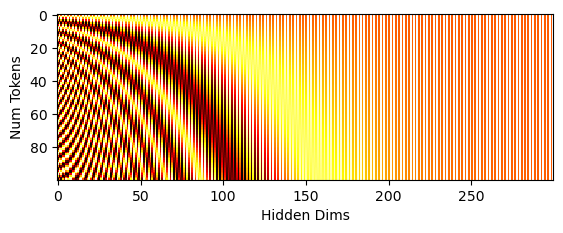

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(get_positional_embeddings(100,300),cmap="hot",interpolation="nearest")
plt.xlabel("Hidden Dims")
plt.ylabel("Num Tokens")
plt.show()

Add PE to the model

In [11]:
class VisionTransformer(nn.Module):
    def __init__(self,chw=(3,64,64),n_patches =8) -> None:
        super().__init__()
        self.chw = chw
        self.n_patches = n_patches
        
        assert chw[1]%n_patches == 0
        assert chw[2]%n_patches == 0
        
        self.patch_size = (chw[1]/n_patches,chw[2]/n_patches)
        # linear mapper
        self.input_d = int(chw[0]*self.patch_size[0]*self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d,self.hidden_d)
        # class token
        self.class_token= nn.Parameter(t.rand(1,self.hidden_d))
        # positional encoding
        self.pos_embd = nn.Parameter(get_positional_embeddings(self.n_patches**2+1,self.hidden_d))
    def forward(self,images:Tensor)->Tensor:
        # 1. [n,c,h,w] -> [n,p^2,chw/p^2]
        patches = patchfy(images)
        # 2. [n,p^2,chw/p^2] -> [n,p^2,h]
        tokens = self.linear_mapper.forward(patches)
        # 3. [n,p^2,h] -> [n,p^2+1,h]
        tokens = t.stack([t.vstack((self.class_token,tokens[i]))for i in range(len(tokens))])
        # 4. [n,p^2+1,h]->[n,p^2+1,h]
        pos_embed = self.pos_embd.repeat(n,1,1)
        return (patches)

# STEP 4: Construct Encoder Block
## 4.1 Layer Normalization (LN)

In [12]:
t.manual_seed(42)

In [13]:
ln=nn.LayerNorm(8,elementwise_affine=False)

ln.forward(t.randn((50,8))).shape

torch.Size([50, 8])

In [14]:
ln.forward(t.randn((100,50,8))).shape

torch.Size([100, 50, 8])

In [15]:
ln.forward(t.tensor([[1.,2.,3.,4.,5.,6.,7.,8.]]))

tensor([[-1.5275, -1.0911, -0.6547, -0.2182,  0.2182,  0.6547,  1.0911,  1.5275]])

In [16]:
t.__version__

'2.0.0+cu118'

In [17]:
for name,param in ln.named_parameters():
    print(name,param)

In [18]:
example = t.tensor([[1.,2.,3.,4.,5.,6.,7.,8.]],dtype=t.float32) 
example = (example- example.mean(dim=-1, keepdim=True))/t.sqrt(example.var(dim=-1, keepdim=True)+1e-5)
example

tensor([[-1.4289, -1.0206, -0.6124, -0.2041,  0.2041,  0.6124,  1.0206,  1.4289]])

Why it is different? But actually they have the same pattern, I have asked New Bing but still can't find the cause of the problem.

In [19]:
del ln

## 4.2 Multi-head Self Attention
Query,Key,Value

like `nn.MultiheadAttention`

Until now, I have found the Multihead attention mechanism is integrated into pytorch in 2.0 Version.

It is important to scan `forward` process carefully, it is not a effecient way to use multi-head attention, but it is clear to show the mechanism.

In [20]:
class MHA(nn.Module):
    def __init__(self,d:int,n_heads=2) -> None:
        super().__init__()
        self.d = d
        self.n_heads = n_heads
        
        assert d%n_heads==0,f"Can't divide dimension {d} into {n_heads} heads"
        
        d_head = int(d/n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head,d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head,d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head,d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax=nn.Softmax(dim=-1)
    
    def forward(self,sequences:Tensor)->Tensor:
        #input: [n,sequence_length,n_hiddens]
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]
                
                seq = sequence[:,head*self.d_head:(head+1)*self.d_head]
                q,k,v = q_mapping.forward(seq),k_mapping.forward(seq),v_mapping.forward(seq)
                
                attention = self.softmax(q@k.T/(self.d_head**0.5))
                seq_result.append(attention@v)
            result.append(t.hstack(seq_result))
        return t.cat([t.unsqueeze(r,dim=0) for r in result])
    

## 4.3 Finish the Encoder Block

In [21]:
class VitBlock(nn.Module):
    def __init__(self,hidden_d:int,n_heads:int,mlp_ratio=4) -> None:
        super().__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads
        
        self.norm1 =nn.LayerNorm(hidden_d)
        self.mha = MHA(hidden_d,n_heads)
        self.norm2 =nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d,mlp_ratio*hidden_d),
            nn.GELU(),
            nn.Linear(hidden_d*mlp_ratio,hidden_d),
        )
    
    def forward(self,x:Tensor) -> Tensor:
        # residual
        out =  x + self.mha(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

Test the Encoder Block

In [22]:
eb = VitBlock(8,2,4)
eb.forward(t.randn(1,8,8)).shape

torch.Size([1, 8, 8])

In [23]:
del eb

# 5. Conbine All things together

Here we added the last component : the classification head
1. Extract the first patch, i.e., the `class_token` as the input features of the classification head
2. Add the classification head to transfom [n,hiddens] to [n,num_classes]

In [24]:
class VisionTransformer(nn.Module):
    def __init__(self,chw=(3,64,64),n_patches =8,n_blocks=2,hidden_d=8,n_heads=2,out_d=10) -> None:
        super().__init__()
        self.chw = chw
        self.n_patches = n_patches
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        self.n_blocks = n_blocks
        
        assert chw[1]%n_patches == 0
        assert chw[2]%n_patches == 0
        
        self.patch_size = (chw[1]/n_patches,chw[2]/n_patches)
        # linear mapper
        self.input_d = int(chw[0]*self.patch_size[0]*self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d,self.hidden_d)
        # class token
        self.class_token= nn.Parameter(t.rand(1,self.hidden_d))
        # positional encoding
        self.pos_embd = nn.Parameter(get_positional_embeddings(self.n_patches**2+1,self.hidden_d))
        # encoder blocks
        self.enc_blocks = nn.ModuleList(
            [VitBlock(hidden_d,n_heads) for _ in range(n_blocks)]
        )
        # classification head
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d,out_d),
            nn.Softmax(dim=-1)
        )
    def forward(self,images:Tensor)->Tensor:
        n,c,h,w = images.shape
        images.to(self.pos_embd.device)
        # 1. [n,c,h,w] -> [n,p^2,chw/p^2]
        patches = patchfy(images,self.n_patches)
        # 2. [n,p^2,chw/p^2] -> [n,p^2,h]
        tokens = self.linear_mapper.forward(patches)
        # 3. [n,p^2,h] -> [n,p^2+1,h]
        tokens = t.stack([t.vstack((self.class_token,tokens[i]))for i in range(len(tokens))])
        # 4. [n,p^2+1,h]->[n,p^2+1,h]
        pos_embed = self.pos_embd.repeat(n,1,1)
        out = tokens + pos_embed
        # 5. [n,p^2+1,h]->[n,p^2+1,h]
        for block in self.enc_blocks:
            out = block.forward(out)
        # 6. [n,p^2+1,h]->[n,h]
        out= out[:,0]
        # 7. [n,h]->[n,num_classes]
        out = self.mlp.forward(out)
        return out

Test

In [25]:
image = t.zeros((1,3,64,64))

vit = VisionTransformer(chw=(3,64,64),n_patches=8,n_blocks=5,hidden_d=8,n_heads=8,out_d = 10)

# shoud output [1,10] shape
vit.forward(image).shape

torch.Size([1, 10])

In [26]:
vit = VisionTransformer(chw=(3,64,64),
                        n_patches=4,
                        n_blocks=12,
                        hidden_d=768,
                        n_heads=12,
                        out_d =200)

# shoud output [1,200] shape
vit.forward(image).shape

torch.Size([1, 200])

# 6. Build-in Transformers
It is recommended to dive into the source code of transformers to understand what they are really doing.

In [27]:
import torchvision as tv

tv.models.vit_l_16
tv.models.vit_l_32
tv.models.vit_b_16
tv.models.vit_b_32
tv.models.vit_h_14

<function torchvision.models.vision_transformer.vit_h_14(*, weights: Optional[torchvision.models.vision_transformer.ViT_H_14_Weights] = None, progress: bool = True, **kwargs: Any) -> torchvision.models.vision_transformer.VisionTransformer>

- vit means VisionTransformer
- l/b/h: The `l` stands for large, the `b` stands for base, and the `h` stands for hybrid
- 16/32: An image is worth 16x16 words (is divided into 16x16 patches), the same as 32.

In [28]:
def calculate_param_num(net:nn.Module):
    """calculate the number of parameters

    Args:
        net (nn.Module): the network.
    """
    return sum(p.numel() for p in net.parameters())

In [29]:
models = [
tv.models.vit_b_16(),
tv.models.vit_b_32(),
tv.models.vit_l_16(),
tv.models.vit_l_32(),
tv.models.vit_h_14(),
]

Let us see the papameter numbers

In [30]:
parm_nums = [calculate_param_num(model) for model in models]
parm_nums

[86567656, 88224232, 304326632, 306535400, 632045800]

In [31]:
parm_nums/np.max(parm_nums)

array([0.13696421, 0.13958519, 0.48149459, 0.48498922, 1.        ])

Print one of the following parameters

In [32]:
models[0]

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

12 layers with hidden_size = 768

Compare our Vit with the bulid-in method.

In [33]:
image.shape

torch.Size([1, 3, 64, 64])

In [34]:
import time
start_time = time.time()
# shoud output [1,200] shape
for _ in range(100):
    vit.forward(image)
end_time = time.time()

print("time_usg: ", end_time - start_time)


time_usg:  2.8987042903900146


In [35]:
model2 = tv.models.VisionTransformer(
    image_size=64,
    patch_size=16,
    num_layers=12,
    num_heads=12,
    hidden_dim=768,
    mlp_dim=768,
    num_classes=200,
)

start_time = time.time()
# shoud output [1,200] shape
for _ in range(100):
    model2.forward(image)
end_time = time.time()

print("time_usg: ", end_time - start_time)

time_usg:  1.961057424545288
